In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt 
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

In [3]:
class Processing:
    def __init__(self, filedataset, begining_training, end_training,end_testing, timestamp, features, target):
        self.timestamp = timestamp
        self.features  = features
        self.begining_training = begining_training
        self.end_training = end_training
        self.end_testing = end_testing
        self.df  = self.importDataset()
        self.x_train = []
        self.y_train = []
        self.x_test  = []
        self.y_test  = []
        self.scaler_x = None
        self.scaler_y = None
        self.target = target
        self.df_training =  None
        self.df_test = None
        self.splitData()
    
    def importDataset(self):
        parser = lambda x: pd.datetime.strptime(x, "%Y.%m.%d %H:%M:%S")
        df = pd.read_csv( filedataset, sep=';', header=0, parse_dates=['time'],date_parser=parser) 
        return df
    
    def selectInterval(self, start, end):
        mask = (self.df['time'] > start) & (self.df['time'] <= end )
        return self.df.loc[mask]
    
    def scalerDataset(self, dataset):
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.scaler_x.fit(dataset)
        self.scaler_y.fit(self.df_training[[target]])
        return self.scaler_x.transform(dataset)

    def processXY(self, dataframe):
        length = len(dataframe)
        x_data = []
        y_data = []
        for i in range(self.timestamp, length):
            x_data.append( dataframe[i-self.timestamp:i,:])
            y_data.append( dataframe[i,self.features.index(target)])
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        x_data = np.reshape(x_data, (x_data.shape[0], self.timestamp, len(features)))
        return x_data, y_data
     
    def splitData(self):
        #Selecionando Intervalos de datas para treino
        self.df_training = self.selectInterval(self.begining_training, self.end_training)
        #selecionando colunas para treino
        self.df_training = self.df_training[self.features]
        #Escalando o dataset de treino usando a funcao MinMax()
        self.x_train = self.scalerDataset(self.df_training)
        #Processando o dataset com o shape adequado para a modelagem 
        self.x_train, self.y_train = self.processXY( self.x_train )
        #Selecionando Intervalos de datas para teste
        self.df_test = self.selectInterval(self.end_training, self.end_testing)
        #selecionando colunas do dataset para teste
        self.x_test = self.df_test[self.features]
        #Escalando o dataset de treino
        self.x_test = self.scaler_x.transform(self.x_test)
        #Processando o dataset com o shape adequado para a modelagem 
        self.x_test , self.y_test  = self.processXY( self.x_test )


#########################Fim da classe de processamento############################################################

class Training:
    def __init__(self, ds, neurons, timestamp, features, epochs):
        self.model = None
        self.ds = ds
        self.neurons = neurons
        self.timestamp = timestamp
        self.features = features
        self.epochs = epochs
        self.trainingLSTM()
        
    def configuringLSTM(self):
        self.model = Sequential()
        self.model.add(LSTM(units = self.neurons, return_sequences = False, input_shape=( self.timestamp , len(self.features) ) ))
        self.model.add(Dropout(0.01))
        self.model.add(Dense(1))
        self.model.compile(loss='mae', optimizer='adam')
    
    def trainingLSTM(self):
        self.configuringLSTM()
        self.model.fit(self.ds.x_train, self.ds.y_train, epochs = self.epochs)
        self.model.save('LSTM_GBPUSD_with_scaler')

#########################Fim da classe de Treinamento#############################################################

class Testing:
    def __init__(self, modelTraining, ds ):
        self.modelTraining  = modelTraining
        self.ds     = ds
        self.y_pred = []
        self.predictedPrice = []
        self.prevision = None
        self.time = None
        self.max = None
        self.min = None
        self.result_to_csv = None
        self.predicting()
        self.estatistical()
    
    def predicting(self):
        self.predictedPrice =  self.modelTraining.model.predict(self.ds.x_test) 
        self.predictedPrice =  self.ds.scaler_y.inverse_transform(self.predictedPrice)
    
    def estatistical(self):
        self.prevision = pd.DataFrame(data=self.predictedPrice, columns=['Previsão'])
        self.time      = pd.DataFrame(data=self.ds.df_test['time'].shift(-self.ds.timestamp).dropna().values, columns=['Data'])
        self.maxima    = pd.DataFrame(data=self.ds.df_test['low1'].shift(-self.ds.timestamp).dropna().values, columns=['Máxima'])
        self.minima    = pd.DataFrame(data=self.ds.df_test['high1'].shift(-self.ds.timestamp).dropna().values, columns=['Minima'])
        frames_to_csv= [ self.time, self.maxima, self.minima, self.prevision ]
        self.result_to_csv = pd.concat( frames_to_csv, axis=1, join='inner')
        
    def saveToCsv(self):
        self.result_to_csv.to_csv('previsoes.csv', mode='a', header=False,index=False)
      
    def graphicMaxMin(self, window):
        y_test = []
        y_test = self.ds.df_test['close1'].shift(-self.ds.timestamp).dropna()
        # shift =  y_test.values[0] - self.prevision.iloc[0,0]
        # self.prevision = self.prevision+shift-0.0005
        plt.plot(y_test[:window], color='red', label='Preço Atual das Ações')
        plt.plot(y_test.index.values[:window], self.prevision.iloc[:window,0] , '.')
        plt.fill_between(y_test.index.values[:window], self.maxima.iloc[:window,0], self.minima.iloc[:window,0], alpha=0.5)
        plt.title('Previsão de Preço de Ações')
        plt.xlabel('Tempo')
        plt.ylabel('Preço das Ações')
        plt.legend()
        plt.show()
        
        

    



In [4]:
begining_training = '2017-01-01 00:00:00'

end_training = '2021-01-01 00:00:00'

end_test = '2022-01-01 00:00:00'

filedataset  = 'arquivos_de_coleta/EURUSD.csv'                                                                                                      
features = ['open','high','low','ticks','close']

target   = 'close'

timestamp = 2

neurons = 120

epochs  = 32

datasetProcessed = Processing( filedataset, begining_training, end_training, end_test, timestamp, features, target  )

# modelTrained = Training( datasetProcessed, neurons, timestamp, features, epochs )

# estatisticalTested  = Testing( modelTrained, datasetProcessed )


<ipython-input-3-09e56deb168d>:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  parser = lambda x: pd.datetime.strptime(x, "%Y.%m.%d %H:%M:%S")


In [5]:
#Seleção das Variáveis
begin = '2018-01-01 01:00:00'       
end = '2018-12-20 22:00:00'
window =  3
dataset = datasetProcessed.selectInterval(begin, end  )
features = ['time','open','high','low','ticks','close']
df = dataset[features]

#Construção da Volatilidade
df['volatile'] = df['low'] - df['high']
df['volatile'] = df['volatile']*100000
df['volatile'] = df['volatile'].astype(int)

#Contrução das Médias de Ticks e Volatilidades
ticks = df['ticks'].rolling(window=window)
df['ticks_mean'] = ticks.mean()
volatile = df['volatile'].rolling(window=window)
df['volatile_mean'] = volatile.mean()
df = df.dropna()

<ipython-input-5-fc6d354e9a26>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['volatile'] = df['low'] - df['high']
<ipython-input-5-fc6d354e9a26>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['volatile'] = df['volatile']*100000
<ipython-input-5-fc6d354e9a26>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [ ]:
# start_date = '2018-01-01 18:45:00'
# end_date   = '2018-08-21 20:00:00'
# mask = (df['time'] > start_date) & (df['time'] <= end_date)
# rebaixamento1 = df.loc[mask]
# print(rebaixamento1[(rebaixamento1['time'] > '2018-08-20 18:45:00') & (df['time'] <= '2018-08-20 20:00:00')].max()['volatile'])
# #plt.plot(rebaixamento1['time'], rebaixamento1['volatile'] ,marker='o', color='red', label='Preço Atual das Ações')
# plt.plot(rebaixamento1['time'], rebaixamento1['volatile_mean'] ,marker='.', color='black', label='Preço Atual das Ações')
# plt.axvline(pd.Timestamp('2018-08-20 19:00:00'), color='g')
# plt.axhline(y=rebaixamento1[(rebaixamento1['time'] > '2018-08-20 18:45:00') & (df['time'] <= '2018-08-20 20:00:00')].max()['volatile'],color='g')
# plt.show()

# # plt.plot(df['time'], df['close'] , color='blue', label='Preço Atual das Ações')

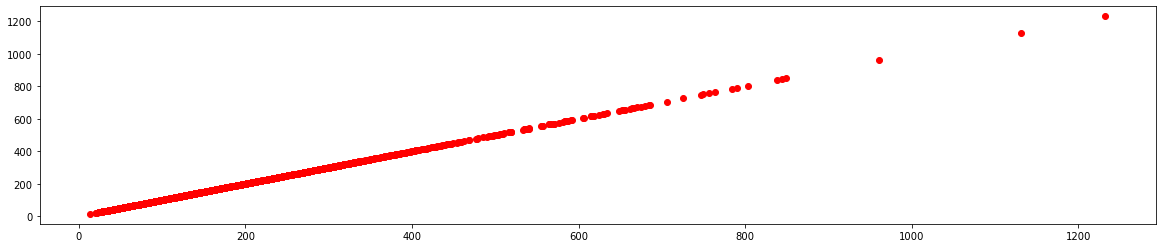

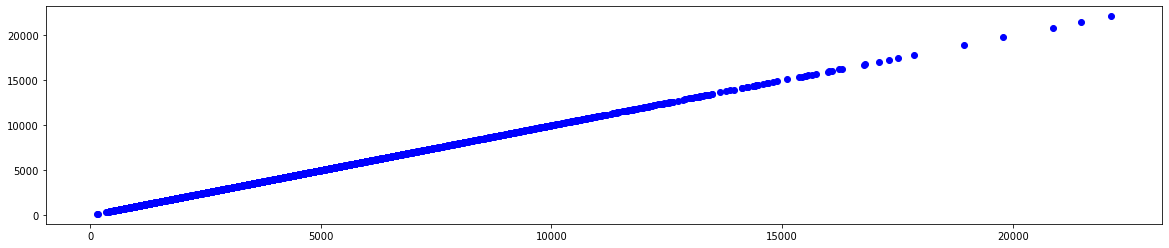

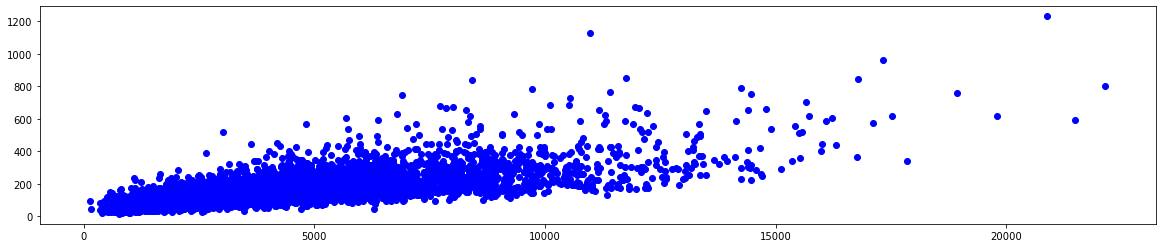

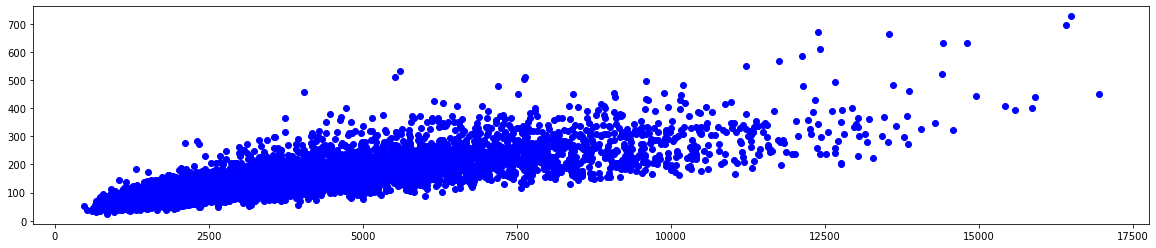

In [6]:
plt.scatter(df['volatile'], df['volatile'] , color='red', label='Preço Atual das Ações')
plt.show()
plt.scatter(df['ticks'], df['ticks'] , color='blue', label='Preço Atual das Ações')
plt.show()
plt.scatter(df['ticks'], df['volatile'] , color='blue', label='Preço Atual das Ações')
plt.show()
plt.scatter(df['ticks_mean'], df['volatile_mean'] , color='blue', label='Preço Atual das Ações')

In [12]:
df

,time,open,high,low,ticks,close,volatile,ticks_mean,volatile_mean
37212,2018-01-02 11:00:00,1.20450,1.20420,1.20704,4300,1.20703,283,4753.5,219.5
37213,2018-01-02 12:00:00,1.20703,1.20612,1.20810,5220,1.20683,197,4760.0,240.0
37214,2018-01-02 13:00:00,1.20683,1.20591,1.20705,3254,1.20592,113,4237.0,155.0
37215,2018-01-02 14:00:00,1.20591,1.20566,1.20688,4200,1.20625,121,3727.0,117.0
37216,2018-01-02 15:00:00,1.20627,1.20561,1.20663,4536,1.20573,101,4368.0,111.0
...,...,...,...,...,...,...,...,...,...
43264,2018-12-20 18:00:00,1.14162,1.14080,1.14327,8044,1.14315,246,8053.0,357.5
43265,2018-12-20 19:00:00,1.14314,1.14309,1.14649,6913,1.14584,340,7478.5,293.0
43266,2018-12-20 20:00:00,1.14584,1.14513,1.14754,4830,1.14703,241,5871.5,290.5
43267,2018-12-20 21:00:00,1.14703,1.14653,1.14849,6652,1.14714,196,5741.0,218.5
